In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Custom Optimizer

## Adaptive Nesterov Momentum

In [49]:
#Adan: Adaptive Nesterov Momentum Algorithm (2024)

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

# Create the CNN MLP+KAN Hybrid Model

## KAN B-Splines
source: https://github.com/Blealtan/efficient-kan/blob/master/src/efficient_kan/kan.py


In [21]:
import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [60]:
class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=16, stride=(2,2))
        self.layer2 = self.make_layer(block,layers[1], output=32, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            KANLinear(32*block.expansion, output_shape, grid_size=5, spline_order=3),
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for _ in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2], input_shape=1, 
                       output_shape=10)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")

ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [16]:
device = 'cpu'

## Dummy Data Testing

In [62]:

tensor1 = torch.randn(size=(1, 28, 28))  # Single image (C, H, W)
print(tensor1.shape)  # Should print torch.Size([3, 128, 128])
print(f"Unsqueeze tensor shape: {tensor1.unsqueeze(dim=0).shape}")

output = fsl_model(tensor1.unsqueeze(dim=0))  # Add batch dimension
print(output)



torch.Size([1, 28, 28])
Unsqueeze tensor shape: torch.Size([1, 1, 28, 28])
tensor([[-0.3939,  0.1735, -0.1767,  0.7799, -0.1388,  0.6004, -0.0647, -0.1424,
          0.4038,  0.4266]], grad_fn=<ViewBackward0>)


# Create Training Loop

In [63]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) #from logits -> prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test Accuracy {test_acc:5f}%")
    return test_loss, test_acc

# Import, Preprocess and Load the Data

In [71]:
transform_train = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

transform_test = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test, download=True)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define Loss, Accuracy and other Parameters

In [73]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
num_of_epochs = 10
num_loss_steps = 1
learning_rate = 0.0001

#Define Accuracy Metric
def calculate_accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

# Train the Model

## Adan

In [74]:
import time
from tqdm.auto import tqdm

seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model_Adan = ResNet_KAN(Block, [2,2], input_shape=1, output_shape=len(train_data.classes))
model_Adan
optimizer_Adan = Adan(params=model_Adan.parameters(), 
                      lr=learning_rate, 
                      betas=(0.92,0.98, 0.95), 
                      weight_decay=1e-2)

results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_epoch = 0
epoch = num_of_epochs
loss_steps = num_loss_steps 
start_adan = time.perf_counter()
for epoch in tqdm(range(start_epoch, num_of_epochs)):
  if epoch % loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                    model = model_Adan,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer_Adan,
                                    calculate_accuracy = calculate_accuracy,
                                    device = device,
                                    loss_steps = loss_steps,
                                    seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                                     model = model_Adan,
                                     loss_fn = loss_fn,
                                     calculate_accuracy = calculate_accuracy,
                                     device = device,
                                     loss_steps = loss_steps,
                                     seed=seed_number)

  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)

end_adan = time.perf_counter()
total_time_adan = end_adan - start_adan
print(f"Total Runtime: {total_time_adan}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 1.54363 | Training Accuracy: 58.7553%
Test Loss 1.12963 | Test Accuracy 78.353901%
Epoch: 1 
Training Loss: 1.01846 | Training Accuracy: 82.3094%
Test Loss 0.88083 | Test Accuracy 87.111863%
Epoch: 2 
Training Loss: 0.84929 | Training Accuracy: 88.6910%
Test Loss 0.78388 | Test Accuracy 90.684713%
Epoch: 3 
Training Loss: 0.76427 | Training Accuracy: 91.6828%
Test Loss 0.72688 | Test Accuracy 92.734873%
Epoch: 4 
Training Loss: 0.71639 | Training Accuracy: 93.2053%
Test Loss 0.69695 | Test Accuracy 93.630573%
Epoch: 5 
Training Loss: 0.68722 | Training Accuracy: 94.2697%
Test Loss 0.67824 | Test Accuracy 94.187898%
Epoch: 6 
Training Loss: 0.66627 | Training Accuracy: 94.9627%
Test Loss 0.66486 | Test Accuracy 94.595939%
Epoch: 7 
Training Loss: 0.64994 | Training Accuracy: 95.5291%
Test Loss 0.65449 | Test Accuracy 94.914411%
Epoch: 8 
Training Loss: 0.63663 | Training Accuracy: 95.9705%
Test Loss 0.64592 | Test Accuracy 95.053742%
Epoch: 9 
Training Loss: 0.6

# Evaluation

## Plot the Loss Curves

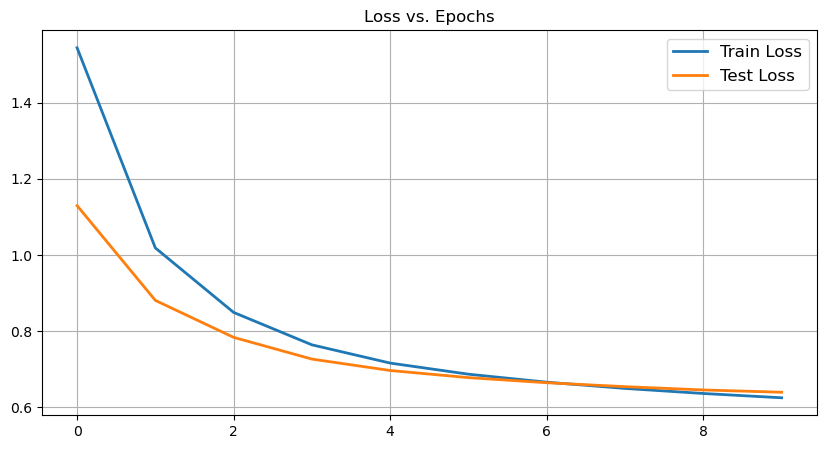

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], linewidth = 2.0, label="Train Loss")
plt.plot(results["test_loss"], linewidth = 2.0, label="Test Loss")
plt.legend(fontsize=12)
plt.title("Loss vs. Epochs")
plt.grid(True)
plt.show()

## Visualize Confusion Matrix

### Define the tools needed

In [76]:
from sklearn.metrics import f1_score, precision_score, recall_score

from torchmetrics.classification import ConfusionMatrix
from torchmetrics.functional import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def infer(data_loader:torch.utils.data.DataLoader,
           model:torch.nn.Module,
           test_data):
    '''
    Make an inference from the trained model on the Test/Unseen Dataset
    '''
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send the data to the proper target device
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logit = model(X)
            # Turn predictions into class labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    y_preds = torch.cat(y_preds)  # This line ensures y_preds is a tensor

    # Ensure test_data.targets is a tensor
    test_targets_tensor = torch.tensor(test_data.targets) if not isinstance(test_data.targets, torch.Tensor) else test_data.targets
    return test_targets_tensor, y_preds

def calculate_metric(y_true, y_pred, average="weighted"): ##--> Choose 'micro', 'macro', or 'weighted'
   
    '''
    Calculate Metric scores of the trained model for f1, precision, and recall 
    '''
     # Convert logits to predicted class labels if necessary
    if y_pred.dim() > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    # Move to CPU and convert to numpy arrays if necessary
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average=average)  
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    
    return f1, precision, recall

def create_confusion_matrix(y_true, y_pred, class_names, num_classes=None, figsize=(19, 10)):
    '''
    This function is to be used for generating confusion matrix 
    '''

    if num_classes is None:
        num_classes = len(class_names)
    
    # Create confusion matrix instance
    confmat = ConfusionMatrix(num_classes=num_classes, task="multiclass")
    confmat_tensor = confmat(preds=y_pred, target=y_true)
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=figsize
    )
    plt.show()


### Show the Metric

  0%|          | 0/157 [00:00<?, ?it/s]

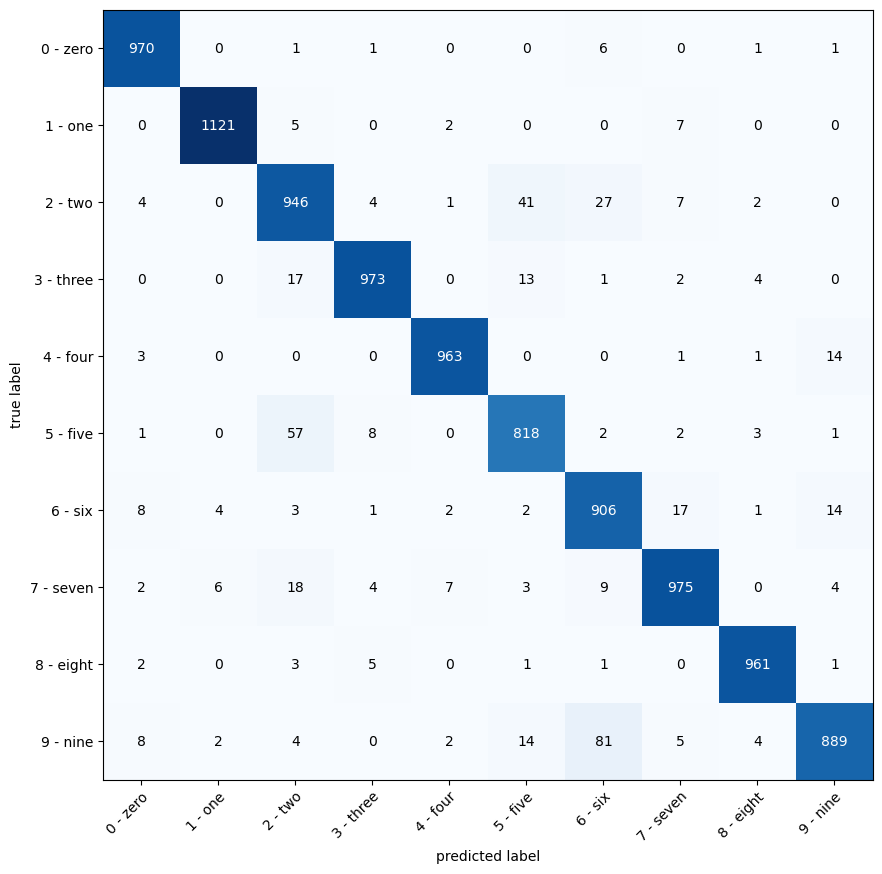

Print F1 score: 0.952264283636229
Precision Score: 0.952990905310621
Recall Score: 0.9522


In [78]:
test_targets1, y_preds1 = infer(test_dataloader, model_Adan, test_data)
create_confusion_matrix(test_targets1, y_preds1, class_names=train_data.classes)
f1_score1, precision_score1, recall_score1 = calculate_metric(test_targets1.cpu(), y_preds1)
print(f"Print F1 score: {f1_score1}")
print(f"Precision Score: {precision_score1}")
print(f"Recall Score: {recall_score1}")

## Visualize Sample Predictions

In [80]:
import random

def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device
    ):
  pred_probs = [];
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

test_samples = []; test_labels = [];
for sample, label in random.sample(list(test_data), k=17):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model = model_Adan,
                              data = test_samples)
pred_classes = pred_probs.argmax(dim=1)

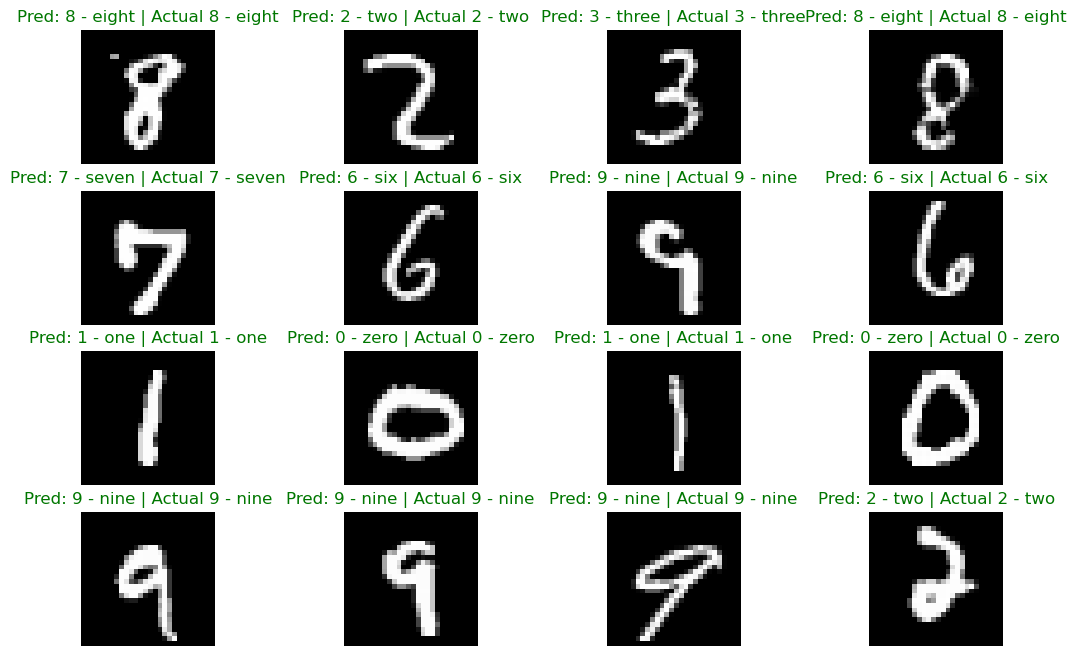

In [39]:
plt.figure(figsize=(13,8))
rows = 4
cols = 4
for i, sample in enumerate(test_samples[: rows*cols]):
  plt.subplot(rows, cols, i+1)
  # plt.imshow(sample.squeeze().permute(1, 2, 0))
  plt.imshow(sample.squeeze(), cmap='gray') 
  #Find the prediction labels
  pred_label = train_data.classes[pred_classes[i]]
  #Get the true labels
  truth_label = test_data.classes[test_labels[i]]

  #Create the title text of the plot
  title_text = f"Pred: {pred_label} | Actual {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, color="#007700")
  else:
    plt.title(title_text, color="#EE0000")
  plt.grid(True)
  plt.axis(False)